In [4]:
# import datetime
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

Data definition :
1. index - Unique Identifier for each row
2. trans_date_trans_time - Transaction DateTime
3. cc_num - Credit Card Number of Customer
4. merchant - Merchant Name
5. category - Category of Merchant
6. amt - Amount of Transaction
7. first - First Name of Credit Card Holder
8. last - Last Name of Credit Card Holder
9. gender - Gender of Credit Card Holder
10. street - Street Address of Credit Card Holder
11. city - City of Credit Card Holder
12. state - State of Credit Card Holder
13. zip - Zip of Credit Card Holder
14. lat - Latitude Location of Credit Card Holder
15. long - Longitude Location of Credit Card Holder
16. city_pop - Credit Card Holder's City Population
17. job - Job of Credit Card Holder
18. dob - Date of Birth of Credit Card Holder
19. trans_num - Transaction Number
20. unix_time - UNIX Time of transaction
21. merch_lat - Latitude Location of Merchant
22. merch_long - Longitude Location of Merchant
23. is_fraud - Fraud Flag <--- Target Class

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kartik2112/fraud-detection")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\USER\.cache\kagglehub\datasets\kartik2112\fraud-detection\versions\1


In [6]:
# Import the data set from path
datas = os.listdir(path)
# Import the mitbih_train and mitbih_test dataset
train_df = pd.read_csv(os.path.join(path, 'fraudTrain.csv'))
test_df = pd.read_csv(os.path.join(path, 'fraudTest.csv'))

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [8]:
train_df.drop(["trans_date_trans_time", "Unnamed: 0", "cc_num", "dob", "lat", "trans_num"], axis = 1, inplace = True)
test_df.drop(["trans_date_trans_time", "Unnamed: 0", "cc_num", "dob", "lat", "trans_num"], axis = 1, inplace = True)

In [9]:
train_x = train_df.drop(columns = ["is_fraud"], axis = 1)
train_y = train_df["is_fraud"]

test_x = test_df.drop(columns = ["is_fraud"], axis = 1)
test_y = test_df["is_fraud"]

is_fraud
0    1289169
1       7506
Name: count, dtype: int64


([<matplotlib.patches.Wedge at 0x1add0ee3490>,
 [Text(-1.0998181131964657, 0.02000294690705531, '1'),
  Text(1.0998181149229591, -0.020002851979370503, '0')],
 [Text(-0.5999007890162539, 0.010910698312939258, '99.4%'),
  Text(0.5999007899579777, -0.010910646534202092, '0.6%')])

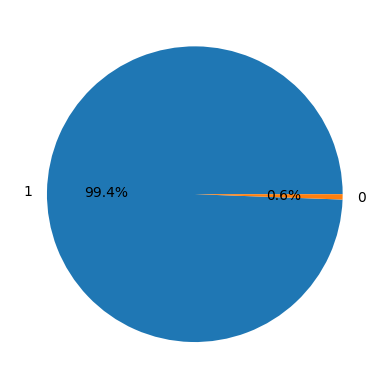

In [10]:
print(train_y.value_counts())

x = [1, 0]
plt.pie(train_y.value_counts(), labels = x, autopct = '%1.1f%%', )

is_fraud
0    553574
1      2145
Name: count, dtype: int64


([<matplotlib.patches.Wedge at 0x1adcbd35a10>,
 [Text(-1.0999191268840707, 0.013338452480854692, '1'),
  Text(1.0999191263279473, -0.01333849833996486, '0')],
 [Text(-0.5999558873913112, 0.007275519535011649, '99.6%'),
  Text(0.5999558870879712, -0.007275544549071741, '0.4%')])

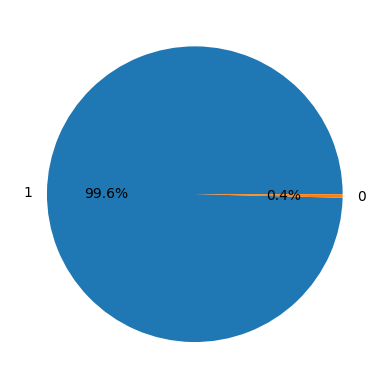

In [11]:
print(test_y.value_counts())

plt.pie(test_y.value_counts(), labels = x, autopct = '%1.1f%%', )

In [12]:
train_x['merchant'] = train_x['merchant'].apply(lambda x : x.replace('fraud_',''))
test_x['merchant'] = test_x['merchant'].apply(lambda x : x.replace('fraud_',''))


train_x['cents'] = (train_x['amt'] - np.floor(train_x['amt'])).astype('float16')
test_x['cents'] = (test_x['amt'] - np.floor(test_x['amt'])).astype('float16')

In [13]:
cat_cols = []
num_cols = []

for col in train_x.columns:
    if train_x[col].dtype == "object":
        cat_cols.append(col)
    else:
        num_cols.append(col)

print(cat_cols)
print(num_cols)

['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job']
['amt', 'zip', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'cents']


In [14]:
# Frequency encoding
for col in cat_cols:
    # Compute the value counts in the training set
    train_value_counts = train_x[col].value_counts()
    test_value_counts = test_x[col].value_counts()  # Use the same value counts for the test set

    # Map the frequencies back to the original column
    train_x[col] = train_x[col].map(train_value_counts)
    test_x[col] = test_x[col].map(test_value_counts)  # Use the same mapping for the test set

In [15]:
sc = StandardScaler()

for col in train_x.columns:
    train_x[col] = sc.fit_transform(train_x[[col]])
    test_x[col] = sc.fit_transform(test_x[[col]])

In [16]:
le = LabelEncoder()
train_x['gender'] = le.fit_transform(train_x['gender'])
test_x['gender'] = le.fit_transform(test_x['gender'])

In [17]:
# int64 to int16
# float 64 to float16
for col in train_x.columns:
    if train_x[col].dtype == "int64":
        train_x[col] = train_x[col].astype('int16')
        test_x[col] = test_x[col].astype('int16')
    elif train_x[col].dtype == "float64":
        train_x[col] = train_x[col].astype('float16')
        test_x[col] = test_x[col].astype('float16')

### Resample

In [18]:
from sklearn.utils import resample
new_train_df = pd.concat([train_x, train_y], axis = 1)
balanced_train = resample(new_train_df[new_train_df['is_fraud'] == 0], 
                          n_samples = len(new_train_df[new_train_df['is_fraud'] == 1]), 
                          random_state = 42)

Train_x = pd.concat([new_train_df[new_train_df['is_fraud'] == 1], balanced_train])
Train_y = Train_x['is_fraud']
Train_x = Train_x.drop(columns = ["is_fraud"], axis = 1)

In [19]:
new_test_df = pd.concat([test_x, test_y], axis = 1)
balanced_test = resample(new_test_df[new_test_df['is_fraud'] == 0], 
                          n_samples = len(new_test_df[new_test_df['is_fraud'] == 1]), 
                          random_state = 42)

test_x = pd.concat([new_test_df[new_test_df['is_fraud'] == 1], balanced_test])
test_y = test_x['is_fraud']
test_x = test_x.drop(columns = ["is_fraud"], axis = 1)

### 模型比較

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as tree
from xgboost import XGBClassifier as XGB
from sklearn.model_selection import KFold, cross_val_score

In [21]:
models = [
    LogisticRegression(max_iter = 1000),
    SVC(kernel='linear', gamma = 0.01, C = 1), 
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(), 
    KNN(n_neighbors = 48), 
    tree(criterion = 'gini', 
         max_depth = 3, 
         min_samples_leaf = 2,
         min_samples_split = 2),
    XGB()
]

titles = [
    "LR", "SVC", 'Adaboost', 'GBoost', "RF", "KNN", "Tree", "XGB"
]

In [22]:
kfold = KFold(n_splits = 5, random_state = 7, shuffle = True)
model_comp = pd.DataFrame()
model_simple = pd.DataFrame()

for i, model in enumerate(models):
    scores = cross_val_score(model, Train_x, Train_y, cv = kfold, scoring = 'accuracy')

    model_comp[titles[i]] = scores
    msg = "%s: %f (%f)" % (titles[i], scores.mean(), scores.std())
    print(msg)

LR: 0.844125 (0.005434)
SVC: 0.857980 (0.005317)
Adaboost: 0.915667 (0.004033)
GBoost: 0.946909 (0.003590)
RF: 0.953171 (0.004672)
KNN: 0.845657 (0.005649)
Tree: 0.907208 (0.003752)
XGB: 0.970557 (0.004012)


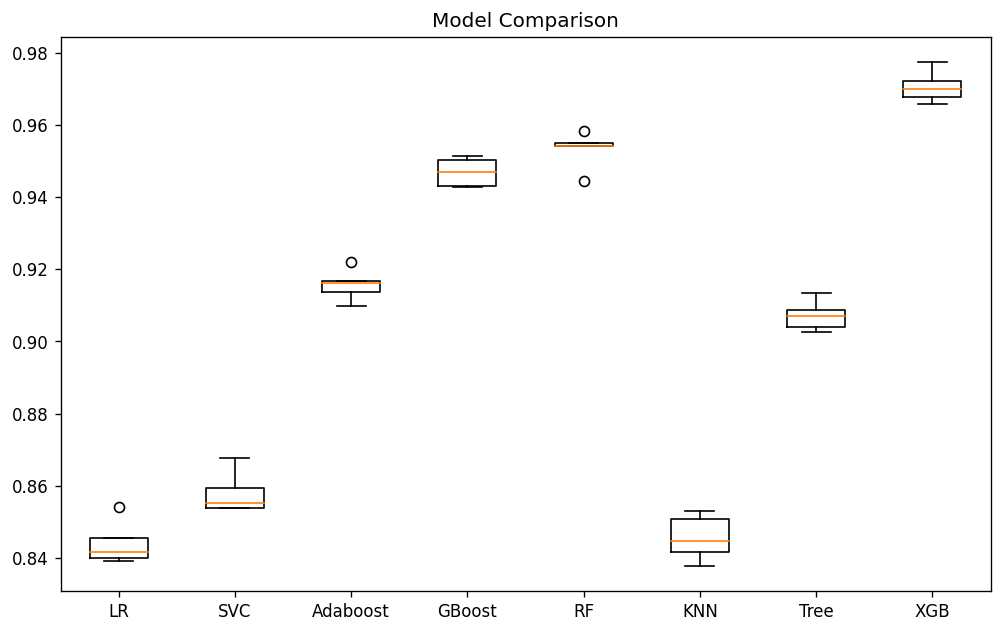

In [23]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=120)

# Matplotlib boxplot
ax.boxplot(model_comp.values, labels=model_comp.columns)
ax.set_title('Model Comparison')

plt.show()